In [175]:
import os
import random
import sys

import git
import numpy as np
from gym import spaces

%matplotlib inline
from matplotlib import pyplot as plt

from PIL import Image

import habitat
from habitat.core.logging import logger
from habitat.core.registry import registry
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.tasks.nav.nav import NavigationTask
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.config.default import get_config as get_baselines_config

In [176]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_path="benchmark/rearrange/pick.yaml",
        overrides=[
            "habitat.environment.max_episode_steps=20",
            "habitat.environment.iterator_options.shuffle=False",
        ],
    )

    try:
        env.close()  # type: ignore[has-type]
    except NameError:
        pass
    env = habitat.Env(config=config)

2024-01-19 14:11:14,150 Initializing dataset RearrangeDataset-v0
2024-01-19 14:11:42,687 initializing sim RearrangeSim-v0
[14:11:43:373154]:[Warning]:[Metadata] SceneDatasetAttributesManager.cpp(206)::setValsFromJSONDoc : (Articulated Object) : No Glob path result for `data/replica_cad/../hab_fetch_1.0/robots/fetch_no_base.urdf`
[14:11:43:564206]:[Warning]:[Metadata] SceneDatasetAttributesManager.cpp(267)::loadAndValidateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_00.navmesh` not found on disk as absolute path or relative to `data/replica_cad`
[14:11:43:564239]:[Warning]:[Metadata] SceneDatasetAttributesManager.cpp(267)::loadAndValidateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_01.navmesh` not found on disk as absolute path or relative to `data/replica_cad`
[14:11:43:564260]:[Warning]:[Metadata] SceneDatasetAttributesManager.cpp(267)::loadAndValidateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_02.navmesh` not found on disk as absolute pat

Renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 545.23.08
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


2024-01-19 14:11:48,300 Initializing task RearrangePickTask-v0
1:43:564520]:[Warning]:[Metadata] SceneDatasetAttributesManager.cpp(267)::loadAndValidateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_17.navmesh` not found on disk as absolute path or relative to `data/replica_cad`
[14:11:43:564538]:[Warning]:[Metadata] SceneDatasetAttributesManager.cpp(267)::loadAndValidateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_18.navmesh` not found on disk as absolute path or relative to `data/replica_cad`
[14:11:43:564564]:[Warning]:[Metadata] SceneDatasetAttributesManager.cpp(267)::loadAndValidateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_19.navmesh` not found on disk as absolute path or relative to `data/replica_cad`
[14:11:43:564581]:[Warning]:[Metadata] SceneDatasetAttributesManager.cpp(267)::loadAndValidateMap : `navmesh_instances` Value : `navmeshes/v3_sc4_staging_20.navmesh` not found on disk as absolute path or relative to `data/replica_cad`
Me

In [177]:
env.number_of_episodes=[3]

In [178]:
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations.utils import (
    observations_to_image,
    overlay_frame,
)
from habitat.tasks.rearrange.utils import (
    CollisionDetails,
    UsesArticulatedAgentInterface,
    batch_transform_point,
    get_angle_to_pos,
    rearrange_logger,
)
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
observations = env.reset()  # noqa: F841

print("Agent acting inside environment.")
count_steps = 0
# To save the video
video_file_path = "data/example_interact.mp4"
video_writer = vut.get_fast_video_writer(video_file_path, fps=30)

while not env.episode_over:
    observations = env.step(env.action_space.sample())  # noqa: F841
    info = env.get_metrics()
    print(info)
    # print(observations)
    render_obs = observations_to_image(observations, info)
    render_obs = overlay_frame(render_obs, info)

    video_writer.append_data(render_obs)

    count_steps += 1
print("Episode finished after {} steps.".format(count_steps))

video_writer.close()
if vut.is_notebook():
    vut.display_video(video_file_path)

Loaded navmesh from data/replica_cad/navmeshes/v3_sc1_staging_02.navmesh
Agent acting inside environment.
Renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 545.23.08
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-bloc

In [179]:
from habitat.tasks.nav.nav import PointGoalSensor
class MultiObjSensor(PointGoalSensor):
    """
    Abstract parent class for a sensor that specifies the locations of all targets.
    """

    def __init__(self, *args, task, **kwargs):
        self._task = task
        self._sim: RearrangeSim
        super().__init__(*args, task=task, **kwargs)

    def _get_observation_space(self, *args, **kwargs):
        n_targets = self._task.get_n_targets()
        return spaces.Box(
            shape=(n_targets * 3,),
            low=np.finfo(np.float32).min,
            high=np.finfo(np.float32).max,
            dtype=np.float32,
        )

class TargetStartSensor(UsesArticulatedAgentInterface, MultiObjSensor):
    """
    Relative position from end effector to target object
    """

    cls_uuid: str = "obj_start_sensor"

    def get_observation(self, *args, observations, episode, **kwargs):
        self._sim: RearrangeSim
        global_T = self._sim.get_agent_data(
            self.agent_id
        ).articulated_agent.ee_transform()
        T_inv = global_T.inverted()
        pos = self._sim.get_target_objs_start()
        return batch_transform_point(pos, T_inv, np.float32).reshape(-1)

In [180]:
observations.keys()
print(observations["ee_pos"])
print(observations["obj_start_sensor"])

[ 0.52761686 -0.25604957  0.94441843]
[-0.10776222  1.4114709   0.68703145]


In [181]:
def display_sample(
    rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):  # noqa: B006
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGB")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new(
            "P", (semantic_obs.shape[1], semantic_obs.shape[0])
        )
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray(
            (depth_obs / 10 * 255).astype(np.uint8), mode="L"
        )
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

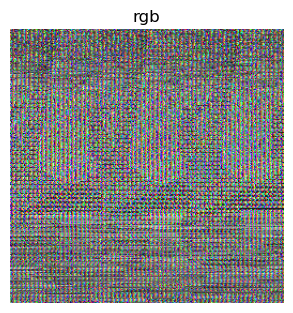

RuntimeError: Given input size: (256x1x256). Calculated output size: (256x0x128). Output size is too small

In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from gym import spaces
# import habitat_baselines.rl.ddppo.policy as pol
from habitat_baselines.rl.ddppo.policy import ( 
    PointNavResNetNet,
    PointNavResNetPolicy,
)
from habitat_baselines.config.default import get_config
from typing import Dict, Optional


class MyPolicy(nn.Module):
    def __init__(self, **kwargs):
        super(MyPolicy, self).__init__()

        ACTION_SPACE = spaces.Discrete(4)

        OBSERVATION_SPACES = {
            "depth_model": spaces.Dict(
                {
                    "depth": spaces.Box(
                        low=0.0,
                        high=1.0,
                        shape=(256, 256, 1),
                        dtype=np.float32,
                    ),
                    "pointgoal_with_gps_compass": spaces.Box(
                        low=-3.4028235e+38,
                        high=3.4028235e+38,
                        shape=(2,),
                        dtype=np.float32,
                    ),
                }
            )
        }
        config = get_config(
            "test/config/habitat_baselines/ddppo_pointnav_test.yaml"
        )
        MODELS = {
            "pointnav_weights.pth": {
                "backbone": "resnet18",
                "observation_space": OBSERVATION_SPACES["depth_model"],
                "action_space": ACTION_SPACE,
            }}
        PTH_GPU_ID: int = 0
        self.device = (
            torch.device("cuda:{}".format(PTH_GPU_ID))
            if torch.cuda.is_available()
            else torch.device("cpu")
        )
        model_weights_path = 'data/new_checkpoints/pointnav_weights.pth'  # Replace with the actual path to your model weights file

        pretrained_state = torch.load(model_weights_path, map_location="cpu")

        self.policy = PointNavResNetPolicy.from_config( config=config,
                                                        observation_space=OBSERVATION_SPACES["depth_model"], 
                                                        action_space=ACTION_SPACE)
        self.policy.load_state_dict(pretrained_state)
        self.rnn_hidden_states: Optional[torch.Tensor] = None
        self.not_done_masks: Optional[torch.Tensor] = None
        self.prev_actions: Optional[torch.Tensor] = None
        # self.policy.to(self.device)
        self.policy.eval()

        
    def forward(self, obs):
        # Extract observations
        depth_image = obs['head_depth']
  
        relative_position = obs["obj_start_sensor"] - obs["ee_pos"]
        rho = np.linalg.norm(relative_position)
        theta = np.arctan2(relative_position[1], relative_position[0])
        display_sample(obs["head_depth"])
        depth_image_tensor = torch.from_numpy(depth_image).permute(2, 0, 1).unsqueeze(0).float()
        # Process observations through the policy
        action_logits, _ = self.policy.act(
            observations={"depth": depth_image_tensor, "target_position": np.array([rho, theta])},
            rnn_hidden_states=self.rnn_hidden_states,
            prev_actions=self.prev_actions,
            masks=None,
            deterministic=False)

        # Convert action logits to actions (0: stop, 1: move forward, 2: pivot left, 3: pivot right)
        action = torch.argmax(action_logits, dim=1).item()

        return action
    


pol=MyPolicy()
# Create an instance of MyPolicy

# policy.load_state_dict(pretrained_state)

# Set the model to evaluation mode
# pol.eval()
obs = env.reset()  
action = pol.forward(obs)
# action = action_data.env_actions.item()
# action_logits= policy(obs)
# print(action_logits)




action = None
obs = env.reset()
# print(obs["head_rgb"])
valid_actions = ["stop","move_forward","turn_left", "turn_right"]
interactive_control = False  # @param {type:"boolean"}
while action != "stop":
    display_sample(obs["head_rgb"])
    print(
        "distance to goal: {:.2f}".format(
            obs["ee_pos"][0]
        )
    )
    print(
        "angle to goal (radians): {:.2f}".format(
            obs["ee_pos"][1]
        )
    )
    obs = env.step(
        {
            "action": action,
        }
    )

env.close()